Benchmarking SqPO rewriting with Neo4j
======================================



Types of rules
----------------
- Single transformation rules (given a node/edge a single clone/merge/add)
- Random rules with uniformly chosen operations (variable size of a lhs/number of operations)
- Rules extracted from the real-world dataset


Types of graphs
-----------------

#### Synthetic graphs


* Complete graph (Networkx's implementation)
 https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.generators.classic.complete_graph.html#networkx.generators.classic.complete_graph

* Directed scale-free graph (Networkx's implementation)

 **TODO:** investigate generation parameters $\alpha$, $\beta$, $\gamma$.
https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.generators.directed.scale_free_graph.html#networkx.generators.directed.scale_free_graph


References
-----------


* Benchmarking for Graph Transformation, Gergely Varr, Andy Schurr, Daniel Varr
  http://www.cs.bme.hu/~gervarro/publication/TUB-TR-05-EE17.pdf

* B. Bollobás, C. Borgs, J. Chayes, and O. Riordan, Directed scale-free graphs, Proceedings of the fourteenth annual ACM-SIAM Symposium on Discrete Algorithms, 132–139, 2003.



In [1]:
import time
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pickle
import importlib
import regraph
from scipy import stats

from regraph import Rule, plot_rule, clone_node
from regraph.neo4j.graphs import Neo4jGraph
from regraph.neo4j.cypher_utils import *

## Mean elapsed time to perform a single operation

### Complete directed graphs (cliques)

In [7]:
# # Generate graphs (Warning: takes some time, see below dumped graphs)
# clique_ns = [int(i) for i in np.logspace(5, 8, 20, base=2)]

# logspaced_cliques = []
# for n in clique_ns:
#     g = nx.DiGraph()
#     nodelist = ["n" + str(nn + 1)for nn in range(n)]
#     g.add_nodes_from(nodelist)
#     edges = []
#     for n1 in nodelist:
#         for n2 in nodelist:
#             edges.append((n1, n2))
#             edges.append((n2, n1))
#     g.add_edges_from(edges)
#     logspaced_cliques.append(g)
# with open("logspaced_cliques.pickle","wb") as f:
#     pickle.dump((clique_ns, logspaced_cliques), f)

In [2]:
# Load dumped data
with open("logspaced_cliques.pickle","rb") as f:
    (clique_ns, logspaced_cliques) = pickle.load(f)
print("Graph sizes to generate: ", clique_ns)

Graph sizes to generate:  [32, 35, 39, 44, 49, 55, 61, 68, 76, 85, 95, 106, 118, 132, 148, 165, 184, 205, 229, 256]


In [3]:
# We define statistics of interest
nx_clique = {
    "clone": [],
    "merge": [],
    "add_node": [],
    "add_edge": [],
    "remove_node": [],
    "remove_edge": []
}
neo4j_clique = {
    "full_clone": [],
    "no_id_gen_clone": [],
#     "no_ignore_edges_clone": [],
    "full_merge": [],
    "no_id_gen_merge": [],
    "add_node": [],
    "add_edge": [],
    "remove_node": [],
    "remove_edge": []
}

In [4]:
# Connect the db
neo4j_g = Neo4jGraph("bolt://localhost:7687", "neo4j", "admin")

In [11]:
# # Collect statistics on clone
# for graph in logspaced_cliques:
#     print("Graph of size {}...".format(len(graph.nodes())))

#     # dump graph into 'graph.csv'
#     with open('/var/lib/neo4j/import/graph.csv', "w+") as f:
#         f.write("uId,vId\n")
#         for u, v in graph.edges():
#             f.write("{},{}\n".format(u, v))

#     # load csv into neo4j database
#     neo4j_g.clear()
#     load_csv_query =\
#         "LOAD CSV WITH HEADERS FROM 'file:///graph.csv' AS csvLine " +\
#         "MERGE (u:node {id: csvLine.uId }) " +\
#         "MERGE (v:node {id: csvLine.vId }) " +\
#         "CREATE (u)-[:edge]->(v) "
#     neo4j_g.execute(load_csv_query)
#     nodes = graph.nodes()

#     # select 100 random nodes to clone
#     random_nodes = np.random.choice(nodes, 30)
    
#     # Clone with no pretty id's generation
#     elapsed_times = []
#     for node in random_nodes:
#         start = time.time()
#         res = neo4j_g.clone_node(node, ignore_naming=True)
#         elapsed_times.append(time.time() - start)
#     neo4j_clique["no_id_gen_clone"].append(np.mean(elapsed_times))
  
#     # Clone with pretty id's + ignore edges
#     elapsed_times = []
#     for node in random_nodes:
#         start = time.time()
#         res = neo4j_g.clone_node(node)
#         elapsed_times.append(time.time() - start)
#     neo4j_clique["full_clone"].append(np.mean(elapsed_times))

#     # Clone with nx
#     elapsed_times = []
#     for node in random_nodes:
#         start = time.time()
#         res = clone_node(graph, node)
#         elapsed_times.append(time.time() - start)
#     nx_clique["clone"].append(np.mean(elapsed_times))

# with open("nx_clique.pickle", "wb") as f:
#     pickle.dump(nx_clique, f)

# with open("neo4j_clique.pickle", "wb") as f:
#     pickle.dump(neo4j_clique, f)

In [6]:
# Collect statistics on clone
for graph in logspaced_cliques[:10]:
    print("Graph of size {}...".format(len(graph.nodes())))

    # dump graph into 'graph.csv'
    with open('/var/lib/neo4j/import/graph.csv', "w+") as f:
        f.write("uId,vId\n")
        for u, v in graph.edges():
            f.write("{},{}\n".format(u, v))

    # load csv into neo4j database
    neo4j_g.clear()
    load_csv_query =\
        "LOAD CSV WITH HEADERS FROM 'file:///graph.csv' AS csvLine " +\
        "MERGE (u:node {id: csvLine.uId }) " +\
        "MERGE (v:node {id: csvLine.vId }) " +\
        "CREATE (u)-[:edge]->(v) "
    neo4j_g.execute(load_csv_query)
    nodes = graph.nodes()
    break
#     # select 100 random nodes to clone
#     random_nodes1 = np.random.choice(nodes, 1)
#     random_nodes2 = np.random.choice(nodes, 1)
    
#     # Clone with no pretty id's generation
#     elapsed_times = []
#     for i in range(len(random_nodes1)):
#         print("neo4j")
#         node1 = random_nodes1[i]
#         node2 = random_nodes2[i]
#         start = time.time()
#         res = neo4j_g.merge_nodes([node1, node2], ignore_naming=True)
#         elapsed_times.append(time.time() - start)
#     neo4j_clique["no_id_gen_merge"].append(np.mean(elapsed_times))
  
#     # load csv into neo4j database
#     neo4j_g.clear()
#     load_csv_query =\
#         "LOAD CSV WITH HEADERS FROM 'file:///graph.csv' AS csvLine " +\
#         "MERGE (u:node {id: csvLine.uId }) " +\
#         "MERGE (v:node {id: csvLine.vId }) " +\
#         "CREATE (u)-[:edge]->(v) "
#     neo4j_g.execute(load_csv_query)
#     nodes = graph.nodes()

#     # Clone with pretty id's + ignore edges
#     elapsed_times = []
#     for i in range(len(random_nodes1)):
#         print("neo4j2")
#         node1 = random_nodes1[i]
#         node2 = random_nodes2[i]
#         start = time.time()
#         res = neo4j_g.merge_nodes([node1, node2])
#         elapsed_times.append(time.time() - start)
#     neo4j_clique["full_merge"].append(np.mean(elapsed_times))

#     # Clone with nx
#     elapsed_times = []
#     for i in range(len(random_nodes1)):
#         print("nx")
#         node1 = random_nodes1[i]
#         node2 = random_nodes2[i]
#         start = time.time()
#         res = merge_nodes(graph, [node1, node2])
#         elapsed_times.append(time.time() - start)
#     nx_clique["merge"].append(np.mean(elapsed_times))

# with open("nx_clique.pickle", "wb") as f:
#     pickle.dump(nx_clique, f)

# with open("neo4j_clique.pickle", "wb") as f:
#     pickle.dump(neo4j_clique, f)

Graph of size 32...


In [ ]:
with open("nx_clique.pickle", "rb") as f:
    nx_clique = pickle.load(f)
with open("neo4j_clique.pickle", "rb") as f:
    neo4j_clique = pickle.load(f)

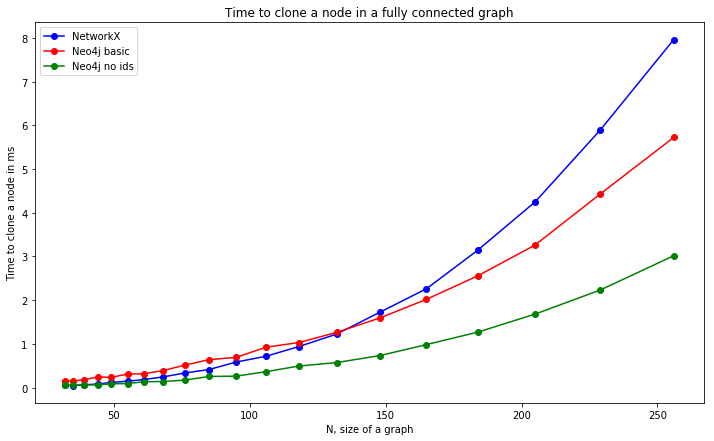

In [161]:
# plot the graph
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(111)
ax.plot(clique_ns, nx_clique["clone"], "bo-", clique_ns, neo4j_clique["full_clone"], "ro-", clique_ns, neo4j_clique["no_id_gen_clone"][:20], "go-")

ax.set_title('Time to clone a node in a fully connected graph')
ax.set_xlabel('N, size of a graph')
ax.set_ylabel('Time to clone a node in ms')
ax.legend(["NetworkX", "Neo4j basic", "Neo4j no ids"])

plt.show()

### Scale-free graphs (fixed params ($\alpha=0.41$, $\beta=0.54$, $\gamma=0.05$), various size)

In [162]:
# # Generate graphs (Warning: takes some time, see below dumped graphs) + TODO: investigate more parameters
# scale_free_ns = [int(i) for i in np.logspace(5, 14, 100, base=2)]

# logspaced_scale_free = []
# for n in scale_free_ns:
#     logspaced_scale_free.append(nx.scale_free_graph(n))

# # dump generated graphs
# with open("log_spaced_scale_free.pickle","wb") as f:
#     pickle.dump((scale_free_ns, logspaced_scale_free), f)

In [163]:
# load generated graphs
with open("log_spaced_scale_free.pickle","rb") as f:
    (scale_free_ns, logspaced_scale_free) = pickle.load(f)
print("Graph sizes to generate: ", scale_free_ns)

Graph sizes to generate:  [32, 34, 36, 38, 41, 43, 46, 49, 52, 56, 60, 64, 68, 72, 77, 82, 87, 93, 99, 105, 112, 120, 128, 136, 145, 154, 164, 175, 186, 198, 211, 225, 240, 256, 272, 290, 309, 329, 350, 373, 397, 423, 451, 480, 512, 545, 580, 618, 658, 701, 747, 795, 847, 902, 961, 1024, 1090, 1161, 1237, 1317, 1403, 1494, 1591, 1695, 1805, 1922, 2048, 2181, 2323, 2474, 2635, 2806, 2989, 3183, 3390, 3610, 3845, 4096, 4362, 4646, 4948, 5270, 5612, 5978, 6366, 6780, 7221, 7691, 8192, 8724, 9292, 9896, 10540, 11225, 11956, 12733, 13561, 14443, 15383]


In [164]:
# We define statistics of interest
nx_scale_free = {
    "clone": [],
    "merge": [],
    "add_node": [],
    "add_edge": [],
    "remove_node": [],
    "remove_edge": []
}
neo4j_scale_free = {
    "full_clone": [],
    "no_id_gen_clone": [],
#     "no_ignore_edges_clone": [],
    "merge": [],
    "add_node": [],
    "add_edge": [],
    "remove_node": [],
    "remove_edge": []
}

In [165]:
# # np.var(largest_conected_components_sizes)
# for g in logspaced_scale_free:
#     print("Graph of size {}...".format(len(g.nodes())))

#     graph = nx.relabel_nodes(g, {n: "n" + str(n) for n in g.nodes()})

#     # dump graph into 'graph.csv'
#     with open('/var/lib/neo4j/import/graph.csv', "w+") as f:
#         f.write("uId,vId\n")
#         for u, v in graph.edges():
#             f.write("{},{}\n".format(u, v))

#     # load csv into neo4j database
#     neo4j_g.clear()
#     load_csv_query =\
#         "LOAD CSV WITH HEADERS FROM 'file:///graph.csv' AS csvLine " +\
#         "MERGE (u:node {id: csvLine.uId }) " +\
#         "MERGE (v:node {id: csvLine.vId }) " +\
#         "CREATE (u)-[:edge]->(v) "
#     neo4j_g.execute(load_csv_query)
#     nodes = graph.nodes()

#     # select 100 random nodes to clone
#     random_nodes = np.random.choice(nodes, 100)
        
#     # Clone with no pretty id's generation
#     elapsed_times = []
#     for node in random_nodes:
#         start = time.time()
#         res = neo4j_g.clone_node(node, ignore_naming=True)
#         elapsed_times.append(time.time() - start)
#     neo4j_scale_free["no_id_gen_clone"].append(np.mean(elapsed_times))
    
#     # Clone with pretty id's generation + ignoreEdges
#     elapsed_times = []
#     for node in random_nodes:
#         start = time.time()
#         res = neo4j_g.clone_node(node)
#         elapsed_times.append(time.time() - start)
#     neo4j_scale_free["full_clone"].append(np.mean(elapsed_times))
    
#     # Clone 100 random nodes in nx graph
#     elapsed_times = []
#     for node in random_nodes:
#         start = time.time()
#         res = clone_node(graph, node)
#         elapsed_times.append(time.time() - start)
#     nx_scale_free["clone"].append(np.mean(elapsed_times))

# with open("nx_scale_free.pickle", "wb") as f:
#     pickle.dump(nx_scale_free, f)

# with open("neo4j_scale_free.pickle", "wb") as f:
#     pickle.dump(neo4j_scale_free, f)

In [166]:
with open("nx_scale_free.pickle", "rb") as f:
    nx_scale_free = pickle.load(f)
with open("neo4j_scale_free.pickle", "rb") as f:
    neo4j_scale_free = pickle.load(f)

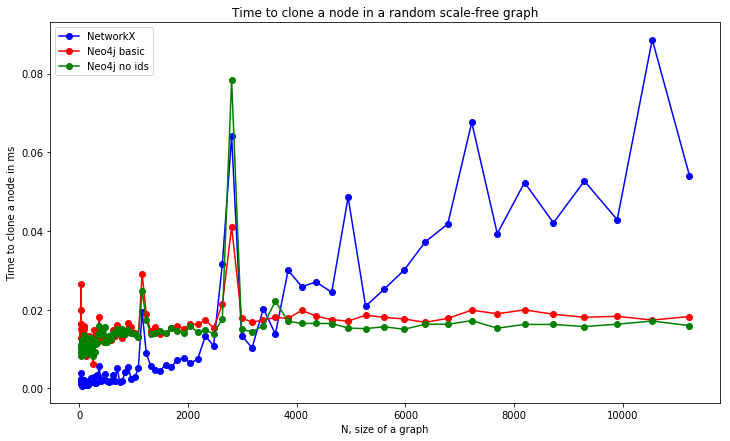

In [167]:
# plot the graph
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(111)
ax.plot(scale_free_ns[:94], nx_scale_free["clone"][:94], "bo-", scale_free_ns[:94], neo4j_scale_free["full_clone"][:94], "ro-", scale_free_ns[:94], neo4j_scale_free["no_id_gen_clone"][:94], "go-")

ax.set_title('Time to clone a node in a random scale-free graph')
ax.set_xlabel('N, size of a graph')
ax.set_ylabel('Time to clone a node in ms')
ax.legend(["NetworkX", "Neo4j basic", "Neo4j no ids"])

plt.show()

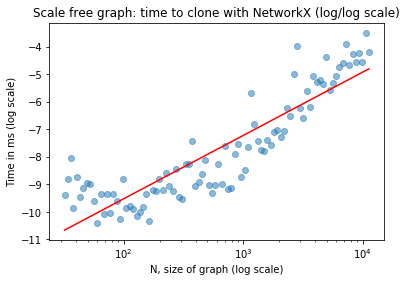

Exponent:  0.692686886568


In [168]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("Scale free graph: time to clone with NetworkX (log/log scale)")
ax.set_xlabel('N, size of graph (log scale)')
ax.set_ylabel('Time in ms (log scale)')

slope, intercept, r_value, p_value, std_err = stats.linregress(np.log2(scale_free_ns[:94]), np.log2(nx_scale_free["clone"][:94]))

ax.scatter(scale_free_ns[:94], np.log2(nx_scale_free["clone"][:94]), alpha=0.5)
ax.set_xscale('log')

x = scale_free_ns[:94]
y = [np.log2(xx**slope * 2 ** intercept) for xx in x]
ax.plot(x, y, color="red")

plt.show()
print("Exponent: ", slope)

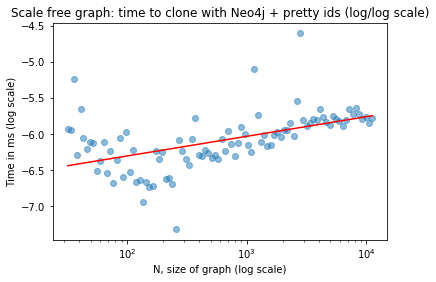

Exponent:  0.0817699130295


In [169]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("Scale free graph: time to clone with Neo4j + pretty ids (log/log scale)")
ax.set_xlabel('N, size of graph (log scale)')
ax.set_ylabel('Time in ms (log scale)')

slope, intercept, r_value, p_value, std_err = stats.linregress(np.log2(scale_free_ns[:94]), np.log2(neo4j_scale_free["full_clone"]))

ax.scatter(scale_free_ns[:94], np.log2(neo4j_scale_free["full_clone"]), alpha=0.5)
ax.set_xscale('log')

x = scale_free_ns[:94]
y = [np.log2(xx**slope * 2 ** intercept) for xx in x]
ax.plot(x, y, color="red")

plt.show()
print("Exponent: ", slope)

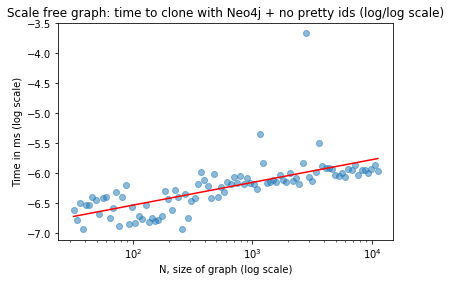

Exponent:  0.113929285555


In [170]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("Scale free graph: time to clone with Neo4j + no pretty ids (log/log scale)")
ax.set_xlabel('N, size of graph (log scale)')
ax.set_ylabel('Time in ms (log scale)')

slope, intercept, r_value, p_value, std_err = stats.linregress(np.log2(scale_free_ns[:94]), np.log2(neo4j_scale_free["no_id_gen_clone"]))

ax.scatter(scale_free_ns[:94], np.log2(neo4j_scale_free["no_id_gen_clone"]), alpha=0.5)
ax.set_xscale('log')

x = scale_free_ns[:94]
y = [np.log2(xx**slope * 2 ** intercept) for xx in x]
ax.plot(x, y, color="red")

plt.show()
print("Exponent: ", slope)